In [1]:
# !pip install gym

# Dependency

In [1]:
# importing required modules
import numpy as np
import gym
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Creating Environment

In [2]:
## Create the environment from gym module
## Here we'll create the FrozenLake environment.
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)

In [3]:
action_size=env.action_space.n       ## Actions we can perform
state_size=env.observation_space.n   ## States in which we can be (Position of player)
print("action_size : ",action_size,"\nstate_size  : ",state_size)

action_size :  4 
state_size  :  16


In [4]:
print(f"Environment_ID    : {env.spec.id}")
print(f"Action_Space      : {env.action_space}")
print(f"Observation_space : {env.observation_space} ")  
print(f"Reward_range      : {env.reward_range}")
print(f"Render_mode       : {env.render_mode}")
print(f"Shape_of_Reset    : {env.reset()[0]}")
print(f"Reward_threshold  : {env.spec.reward_threshold}")
print(f"Max_episode_steps : {env.spec.max_episode_steps}")
n_states = env.observation_space.n
n_actions = env.action_space.n


Environment_ID    : FrozenLake-v1
Action_Space      : Discrete(4)
Observation_space : Discrete(16) 
Reward_range      : (0, 1)
Render_mode       : None
Shape_of_Reset    : 0
Reward_threshold  : 0.7
Max_episode_steps : 100


In [5]:
# We can perform 4 actions in which we can move
# 0=left
# 1=down
# 2=right
# 3=up
env.action_space.sample() # return value between 0 and 3

0

Return random state between 0 and 15 :- 6


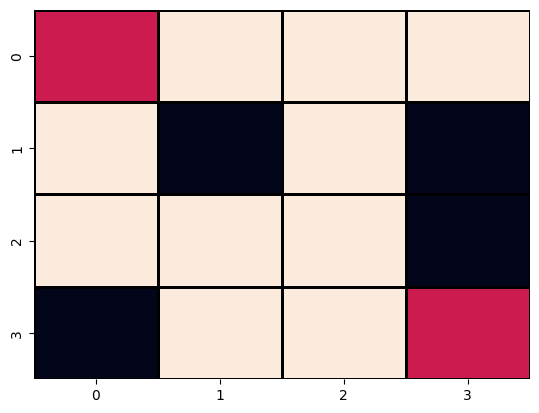

In [6]:
# our player can be in 16 states mens 16 positions
data=np.array([10,20,20,20,20,0,20,0,20,20,20,0,0,20,20,10]).reshape(4,-1)
sns.heatmap(data,cbar=False,linewidths=2,linecolor="k")
print("Return random state between 0 and 15 :-",env.observation_space.sample())#each time value changes
plt.show() # below are all possible states
# 5, 7, 11 , 12 has a hole ,on that state game will terminate
# at sate 15 we will win

In [7]:
## reward  
env.reward_range # reward can be 0 or 1

(0, 1)

In [8]:
env.reset()
action=2 # 4 actions we can perform [0,1,2,3]
env.step(action) # returns after taking action (2) our new state and reward 

(1, 0.0, False, False, {'prob': 1.0})

In [9]:
# reset the state to zero
env.reset()

(0, {'prob': 1})

# Baseline of Model

In [14]:
# If model Takes random actions

num_episode=1000
total_reward=[]
for episode in range(num_episode):
    state=env.reset()
    done=False
    reward=0
    while not done:
        action=env.action_space.sample()
        new_state,reward,done,info,_=env.step(action)
        state=new_state
        reward+=reward
    total_reward.append(reward)
    
#     print(f"Episode {episode+1} Reward  {reward}")
print(f"Maximum Score {(sum(total_reward)/num_episode)*100} in {num_episode} episodes")
print("This is our baseline our trained model should perform better than it ")

Maximum Score 2.0 in 1000 episodes
This is our baseline our trained model should perform better than it 


In [15]:
# we will create a Q-table of shape (state)*(action)that is 16 rows and 4 columns
# Q table stores the return value 
# return value at each state by performing each action like [0,1,2,3]
qtable=np.zeros([state_size,action_size])
print("shape : ",qtable.shape)
qtable

shape :  (16, 4)


array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

# HyperParameter

In [16]:
# Important parameters for algo
total_episode = 10000        # Total episodes
learning_rate = 0.7          # Learning rate
max_steps = 99                # Max steps per episode
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005             # Exponential decay rate for exploration prob


# Model Creation & Training

In [21]:
# List of rewards
rewards=[]

for episode in range(total_episode):
    # Reset the environment
    state=env.reset()[0]
    step=0
    done=False # if done true means reached the goal or fall in a hole
    total_rewards=0  # 
    for steps in range(max_steps):
        # Choose an action a in the current state (s)
        ## First we randomize a number between 0 and 1
        tradeoff=np.random.uniform(0,1)
        ## If this number > greater than epsilon then exploitation (taking the biggest Q value for this state)
        if tradeoff > epsilon:
            action=np.argmax(qtable[state,:]) # taking value from q table
            
        else:
        # Else doing a random choice then exploration
            action=env.action_space.sample()
        
        # after taking certain action in environment in which new state we will be 
        # by using env.step(ation) we will get new state and reward 
        new_state,reward,done,info,_=env.step(action)
        
        # Bellmen Equation
        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        qtable[state,action]=  qtable[state,action] + learning_rate * (
                    reward + gamma * np.max(qtable[new_state,:]) - qtable[state,action] )

        total_rewards+=reward
        # changing the current state
        state=new_state
        # if Done (if we're dead) or win the game : finish episode
        if done==True:
            break
        # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)
    
print("Score over time: " +  str(sum(rewards)/total_episode))
print(qtable)

Score over time: 0.968
[[0.73509189 0.77378094 0.77378094 0.73509189]
 [0.73509189 0.         0.81450625 0.77378094]
 [0.77378094 0.857375   0.77378094 0.81450625]
 [0.81450625 0.         0.77376571 0.77378094]
 [0.77378094 0.81450625 0.         0.73509189]
 [0.         0.         0.         0.        ]
 [0.         0.9025     0.         0.81450625]
 [0.         0.         0.         0.        ]
 [0.81450625 0.         0.857375   0.77378094]
 [0.81450625 0.9025     0.9025     0.        ]
 [0.857375   0.95       0.         0.857375  ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.9025     0.95       0.857375  ]
 [0.9025     0.95       1.         0.9025    ]
 [0.         0.         0.         0.        ]]


# Model Evaluation

In [22]:
## as we can see the average reward is increasing as our model is gaining experience 
# at 10000 episode aur reward id 99.6 means our model is 99.6 time moving in correct direction
rewards_per_thosand_episodes = np.split(np.array(rewards),total_episode/1000)
count=1000
print("Average Reward per 1000 episodes")
for r in rewards_per_thosand_episodes:
    print (count," : ",(sum(r)/1000))
    count+=1000

Average Reward per 1000 episodes
1000  :  0.755
2000  :  0.991
3000  :  0.99
4000  :  0.994
5000  :  0.992
6000  :  0.991
7000  :  0.993
8000  :  0.99
9000  :  0.991
10000  :  0.993


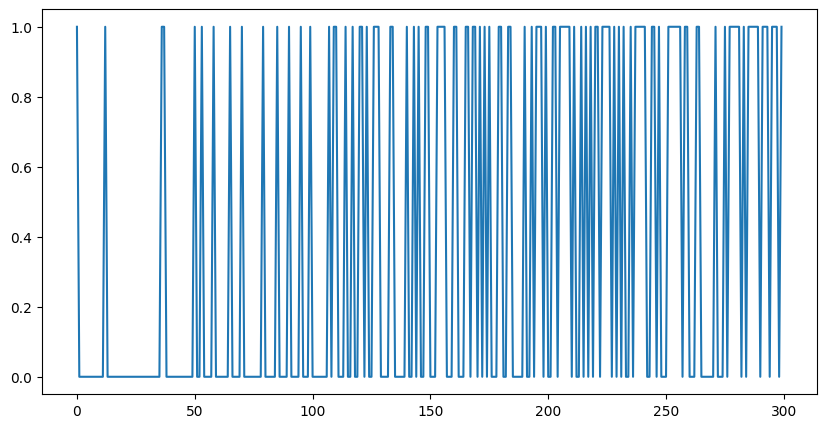

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(rewards[0:300])
plt.show()

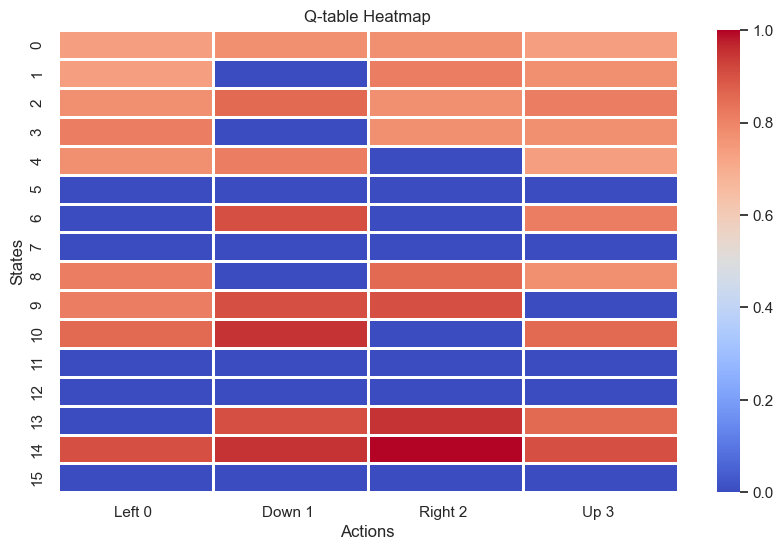

In [26]:
# Create a heatmap using Seaborn
# By looking at this heat map we can see that
# at perticural state what action should be perform
# at 0 state we can see on by taking right we will achive highest return(future reward)
#  after taking right action our state will be changed
# in that state we will see which action gives us higher return or Q-value (future reward)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.heatmap(qtable, cmap="coolwarm",linewidths=1 )
plt.xlabel('Actions')
plt.ylabel('States')
plt.xticks(ticks=[0.5,1.5,2.5,3.5],labels=["Left 0 ","Down 1 ","Right 2 ","Up 3 "])
plt.title('Q-table Heatmap')
plt.show()

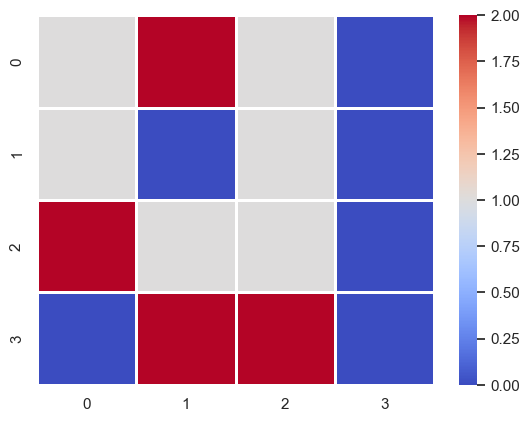

In [27]:
# here we can see in which state which is best action to perform

l=[]
for x in qtable:
    l.append(np.argmax(x))
plane=np.array(l).reshape(-1,4)
sns.heatmap(plane, cmap="coolwarm", linewidths=1 )
plt.show()

# Model Testing

In [28]:
# Testing is model 
action_symbols = ['←', '↓', '→', '↑']
# 2 For life or until learning is stopped
for episode in range(3):
    print("Episode  " ,episode+1)
    # Reset the environment 
    state=env.reset()[0]
    done=False
    total_rewards=0
    for steps in range(50):
#         print(episode)
        action=np.argmax(qtable[state])
        new_state,reward,done,info,_=env.step(action)
        if done==True:
            if new_state in [5,7,11,12]: 
                print(new_state)
                print("Loose")
                break
            else:
                print(new_state)
                print("Win")
                break
        else:
            state=new_state
                
        print(steps,state,action_symbols[action])
     

Episode   1
0 4 ↓
1 8 ↓
2 9 →
3 13 ↓
4 14 →
15
Win
Episode   2
0 4 ↓
1 8 ↓
2 9 →
3 13 ↓
4 14 →
15
Win
Episode   3
0 4 ↓
1 8 ↓
2 9 →
3 13 ↓
4 14 →
15
Win


# Checking Model Performance

In [29]:
# If model Takes random actions

num_episode=1000
total_reward=[]
for episode in range(num_episode):
    state=env.reset()[0]
    done=False
    reward=0
    while not done:
        action=np.argmax(qtable[state,:])
        new_state,reward,done,info,_=env.step(action)
        state=new_state
        reward
    total_reward.append(reward)
    
#     print(f"Episode {episode+1} Reward  {reward}")
print(f"Maximum Score {(sum(total_reward)/num_episode)*100} in {num_episode} episodes")
print("Model perform better than baseline ")


Maximum Score 100.0 in 1000 episodes
Model perform better than baseline 


# Visualizing model playing

In [30]:
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False,render_mode="human")

num_episode=10
total_reward=[]
for episode in range(num_episode):
    state=env.reset()[0]
    done=False
    reward=0
    while not done:
        env.render()
        action=np.argmax(qtable[state,:])
        new_state,reward,done,info,_=env.step(action)
        state=new_state
        reward
    total_reward.append(reward)
    print(f"Episode {episode+1} Reward  {reward}")

env.close()

Episode 1 Reward  1.0
Episode 2 Reward  1.0
Episode 3 Reward  1.0
Episode 4 Reward  1.0
Episode 5 Reward  1.0
Episode 6 Reward  1.0
Episode 7 Reward  1.0
Episode 8 Reward  1.0
Episode 9 Reward  1.0
Episode 10 Reward  1.0


In [35]:
from ipywidgets import Output
from IPython import display
import time
env=gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False,render_mode="human")
# The following three lines are for rendering purposes only.
# They allow us to render the env frame-by-frame in-place
# (w/o creating a huge output which we would then have to scroll through).
out = Output()
display.display(out)
with out:
    # Putting the Gym simple API methods together.
    # Here is a pattern for running a bunch of episodes.
    num_episodes = 1 # Number of episodes you want to run the agent
    total_reward = 0.0  # Initialize reward to 0
    # Loop through episodes
    for ep in range(num_episodes):
        # Reset the environment at the start of each episode
        state = env.reset()[0]
        done = False
        # Loop through time steps per episode
        while True:
            action=np.argmax(qtable[state,:])
            new_obs, reward, done, info,_ = env.step(action)
            total_reward += reward
            state=new_obs
            # If the epsiode is up, then start another one
            if done:
                break
            # Render the env (in place).
            time.sleep(0.5)
            out.clear_output(wait=True)
            print(f"episode: {ep+1}")
            print(f"obs: {new_obs}, reward: {total_reward}, done: {done}")
            env.render()
time.sleep(3)
env.close()

Output()

 Thank You..

End....